<a href="https://colab.research.google.com/github/ereny123/Multitasking-MThesis-2024/blob/main/Pytorch_NET_Multitask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

In [ ]:
#create a model class
class Model(nn.Module):

  def __init__(self, in_tasks=9, in_stim=9, hidden=100, output=9, bias_weight=-2, coeff=0.3, thresh=0.0001):
    super().__init__()

    #Set Parameters
    self.bias_weight = bias_weight   # default bias weight
    self.coeff = coeff
    self.thresh = thresh

    self.task_hidden=nn.Linear(in_tasks, hidden)    #input layer(tasks) --> hidden layer
    self.stim_hidden=nn.Linear(in_stim, hidden)     #input layer(stimuls) --> hidden layer
    self.task_out=nn.Linear(in_tasks, output)       #Input Layer(tasks) --> output layer
    self.hidden_out=nn.Linear(hidden, output)       #hidden layer --> output layer

    self.task_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_tasks).uniform_(-0.1, 0.1))   #input(tasks)-->hidden  weight
    self.task_out.weight=nn.Parameter(torch.FloatTensor(output, in_tasks).uniform_(-0.1, 0.1))      #input(tasks) --> output weight
    self.stim_hidden.weight=nn.Parameter(torch.FloatTensor(hidden, in_stim).uniform_(-0.1, 0.1))    #input(stimulus) -->hidden weight
    self.hidden_out.weight=nn.Parameter(torch.FloatTensor(output, hidden).uniform_(-0.1, 0.1))      #hidden-->output  weight


    self.task_hidden.bias=nn.Parameter(torch.ones(hidden) * bias_weight)                   #hidden layer bias
    self.hidden_out.bias=nn.Parameter(torch.ones(output) * bias_weight)                    #output layer bias

  def forward(self, taskData, stimulusData):

    h_act=torch.sigmoid(self.task_hidden(taskData)+self.stim_hidden(stimulusData))   #hidden layer activation
    out_act= torch.sigmoid(self.hidden_out(h_act)+self.task_out(taskData))           #output layer activation

    return h_act, out_act


#Train Online Method using back propagation
def trainOnline(model, taskData, stimulusData, targetData, iterations, thresh=0.0001, lr=0.1):

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    MSE_log = []

    with tqdm(total=iterations) as pbar:
        for i in range(iterations):
            optimizer.zero_grad()
            h_act, out_act = model(taskData, stimulusData)
            loss = criterion(out_act, targetData)
            loss.backward()
            optimizer.step()
            MSE = loss.item()
            MSE_log.append(MSE)

            if MSE < thresh:
                break


            pbar.set_postfix({'MSE': MSE})
            pbar.update(1)

    return MSE_log



#Reinforcement learning using REINFORCE algorithm
def reinforce_train(model, optimizer, taskData, stimulusData, reward):

    optimizer.zero_grad()

    _, outputs = model(taskData, stimulusData)
    log_probs = torch.log(outputs.squeeze(0))

    # REINFORCE loss
    loss = -log_probs * reward
    loss = loss.mean()
    #reward = torch.sum(outputs * targetData)
    loss.backward()
    optimizer.step()

    return loss.item()



# Define training loop
def train_Rein(model, taskData, stimulusData, targetData, num_episodes=1000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Define optimizer
    losses = [] # To store losses at each episode

    for episode in range(1, num_episodes + 1):
        loss = reinforce_train(model, optimizer, taskData, stimulusData, targetData) # Train using REINFORCE
        losses.append(loss)

        if episode % 100 == 0:  #Logging
            print(f"Episode {episode}/{num_episodes} | Loss: {loss:.3f}")

    return losses

In [ ]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [ ]:
# Generate training data
def generate_dataset_multitask(split_ratio=None):

  #Generate stimulusData Patterns
  stimulusData = torch.tensor([ [0, 0, 1, 0, 0, 1, 0, 0, 1],
                                [0, 0, 1, 0, 0, 1, 0, 1, 0],
                                [0, 0, 1, 0, 0, 1, 1, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0, 1],
                                [0, 0, 1, 0, 1, 0, 0, 1, 0],
                                [0, 0, 1, 0, 1, 0, 1, 0, 0],
                                [0, 0, 1, 1, 0, 0, 0, 0, 1],
                                [0, 0, 1, 1, 0, 0, 0, 1, 0],
                                [0, 0, 1, 1, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0, 1],
                                [0, 1, 0, 0, 1, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 1, 0, 1, 0],
                                [0, 1, 0, 0, 0, 1, 1, 0, 0],
                                [0, 1, 0, 0, 1, 0, 0, 1, 0],
                                [0, 1, 0, 0, 1, 0, 1, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0, 1],
                                [0, 1, 0, 1, 0, 0, 0, 1, 0],
                                [0, 1, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 0, 1, 0, 0, 1],
                                [1, 0, 0, 0, 0, 1, 0, 1, 0],
                                [1, 0, 0, 0, 0, 1, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 0, 1],
                                [1, 0, 0, 1, 0, 0, 0, 1, 0],
                                [1, 0, 0, 1, 0, 0, 1, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 1, 0],
                                [1, 0, 0, 0, 1, 0, 1, 0, 0]
                                                           ] *20 , dtype=torch.float)


# Generate task data patterns
  taskDatapattern = torch.tensor([

    [1, 1, 1, 0, 0, 0, 0, 0, 0] , #Task 1
    [1, 1, 0, 1, 0, 0, 0, 0, 0] , #Task 2
    [1, 1, 0, 0, 1, 0, 0, 0, 0] , #Task 3
    [1, 1, 0, 0, 0, 1, 0, 0, 0] , #Task 4
    [1, 1, 0, 0, 0, 0, 1, 0, 0] , #Task 5
    [1, 1, 0, 0, 0, 0, 0, 1, 0] , #Task 6
    [1, 1, 0, 0, 0, 0, 0, 0, 1] , #Task 7
    [1, 0, 1, 0, 0, 0, 0, 0, 1] , #Task 8
    [1, 0, 0, 1, 0, 0, 0, 0, 1] , #Task 9
    [1, 0, 0, 0, 1, 0, 0, 0, 1] , #Task 10
    [1, 0, 0, 0, 0, 1, 0, 0, 1] , #Task 11
    [1, 0, 0, 0, 0, 0, 1, 0, 1] , #Task 12
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 13
    [1, 0, 0, 0, 0, 0, 0, 1, 1] , #Task 14
    [0, 1, 0, 0, 0, 0, 0, 1, 1] , #Task 15
    [0, 0, 1, 0, 0, 0, 0, 1, 1] , #Task 16
    [0, 0, 0, 1, 0, 0, 0, 1, 1] , #Task 17
    [0, 0, 0, 0, 1, 0, 0, 1, 1] , #Task 18
    [0, 0, 0, 0, 0, 1, 0, 1, 1] , #Task 19
    [0, 0, 0, 0, 0, 0, 1, 1, 1] ] #Task 20

                          , dtype=torch.float)

  taskData = torch.cat([torch.stack([row] * 27) for row in taskDatapattern])

#Define target data
  targetData = torch.zeros((540,9), dtype=torch.float)


  for i in range(len(targetData)):
    for j in range(0, len(targetData[i]), 3):
        if taskData[i, j:j+3].sum() > 0:
            targetData[i, j:j+3] = stimulusData[i, j:j+3]


  # Split into training and validation sets
    dataset_size = len(stimulusData)
    split_index = int(split_ratio * dataset_size)  # Determine split index

    training_set = (stimulusData[:split_index], taskData[:split_index], targetData[:split_index])
    validation_set = (stimulusData[split_index:], taskData[split_index:], targetData[split_index:])

  return training_set, validation_set

In [ ]:
training_set, validation_set = generate_dataset_multitask(split_ratio=0.7)

In [ ]:
train_stimulus, train_task, train_target = training_set
val_stimulus, val_task, val_target = validation_set

In [ ]:
#check points
print(train_target[50:60])
print(train_task[50:60])

tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0.]])
tensor([[1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 0., 0., 0.]])


In [ ]:
#create an instance for Model
model= Model()

In [ ]:
model(train_stimulus, train_task)

(tensor([[0.1612, 0.1013, 0.1224,  ..., 0.1197, 0.0908, 0.1459],
         [0.1521, 0.1146, 0.1310,  ..., 0.1222, 0.0861, 0.1428],
         [0.1702, 0.1091, 0.1338,  ..., 0.1169, 0.0992, 0.1445],
         ...,
         [0.1872, 0.1285, 0.1353,  ..., 0.1144, 0.1142, 0.1355],
         [0.1839, 0.1406, 0.1492,  ..., 0.1225, 0.0937, 0.1325],
         [0.2049, 0.1341, 0.1524,  ..., 0.1171, 0.1079, 0.1341]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1074, 0.1030, 0.1076,  ..., 0.0914, 0.1598, 0.1066],
         [0.1049, 0.1182, 0.1021,  ..., 0.0930, 0.1612, 0.1012],
         [0.1007, 0.1171, 0.1170,  ..., 0.1022, 0.1632, 0.1048],
         ...,
         [0.1004, 0.1400, 0.1271,  ..., 0.1124, 0.1393, 0.1169],
         [0.0918, 0.1269, 0.1015,  ..., 0.1055, 0.1465, 0.1049],
         [0.0880, 0.1258, 0.1163,  ..., 0.1157, 0.1483, 0.1086]],
        grad_fn=<SigmoidBackward0>))

In [ ]:
#Check Sizes
print("Size of taskData:", train_task.size())
print("Size of stimulusData:", train_stimulus.size())
print("Size of trainData:", train_target.size())

print("Size of Validation Stimulus",val_stimulus.shape)
print("Size of Validation Task",val_task.shape)
print("Size of Validation Target",val_target.shape)


Size of taskData: torch.Size([378, 9])
Size of stimulusData: torch.Size([378, 9])
Size of trainData: torch.Size([378, 9])
Size of Validation Stimulus torch.Size([162, 9])
Size of Validation Task torch.Size([162, 9])
Size of Validation Target torch.Size([162, 9])


In [ ]:
MSE_log = trainOnline(model, train_stimulus, train_task, train_target, 200000)

100%|██████████| 200000/200000 [21:53<00:00, 152.22it/s, MSE=0.000839]


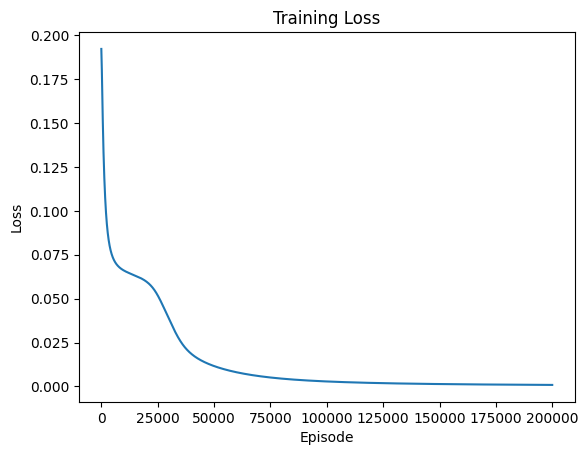

In [ ]:
single_log=plot_losses(MSE_log,'Multi Task')

In [ ]:
# Train the model with Reinforce
Loss_reinforce=train_Rein(model, train_task, train_stimulus, train_target)

Episode 100/1000 | Loss: 0.093
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000


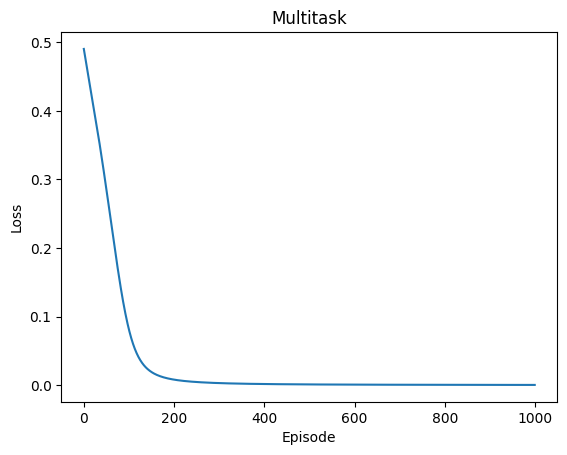

In [ ]:
plot_losses(Loss_reinforce, 'Multitask')

In [ ]:
#Define Evaluation
def evaluate(model, val_task, val_stimulus, val_target):
    model.eval()
    with torch.no_grad():
        _, val_output = model(val_task, val_stimulus)
        criterion = nn.MSELoss()
        val_loss = criterion(val_output, val_target).item()
    model.train()
    return val_loss

In [ ]:
evaluate(model, val_task, val_stimulus, val_target)

0.7945866584777832

In [ ]:
#Define multiple simulations

def run_simulations(n_simulations=100, config=None):
    all_losses = []

    for _ in tqdm(range(n_simulations)):
        model = Model()
        training_set, validation_set = generate_dataset_multitask(split_ratio=0.7)
        taskData, stimulusData, targetData = training_set

        # if config == 'multitask_supervised':
        #     loss_log = trainOnline(model, taskData, stimulusData, targetData, iterations=200000)
        if config == 'multitask_reinforcement':
            loss_log = train_Rein(model, taskData, stimulusData, targetData, num_episodes=1000)

        all_losses.append(loss_log)

    return all_losses

In [ ]:
#Calculate mean and standard error
def calculate_mean_and_standard_error(all_losses):
    min_length = min(len(loss) for loss in all_losses)
    trimmed_losses = [loss[:min_length] for loss in all_losses]
    losses_array = numpy.array(trimmed_losses)
    mean_losses = numpy.mean(losses_array, axis=0)
    std_err_losses = numpy.std(losses_array, axis=0) / numpy.sqrt(losses_array.shape[0])
    return mean_losses, std_err_losses

def plot_standard_error(mean_losses, std_err_losses, title):
    epochs = range(len(mean_losses))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_losses, label='Mean Loss', linewidth=2)
    # Scaling the standard error for visibility
    visible_std_err_losses = std_err_losses * 100
    plt.fill_between(epochs, mean_losses - visible_std_err_losses, mean_losses + visible_std_err_losses, color='b', alpha=0.3, label='Standard Error (Scaled)')
    plt.xlabel('Epochs / Episodes')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{title.replace(" ", "_").lower()}_learning_curve_with_standard_error.png')
    plt.show()


In [ ]:
all_losses_reinforce = run_simulations(n_simulations=100, config='multitask_reinforcement')

  0%|          | 0/100 [00:00<?, ?it/s]

Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


  1%|          | 1/100 [00:02<04:11,  2.54s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


  2%|▏         | 2/100 [00:06<05:19,  3.26s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.089
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


  3%|▎         | 3/100 [00:09<05:34,  3.45s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.083
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


  4%|▍         | 4/100 [00:11<04:27,  2.78s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.083
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


  5%|▌         | 5/100 [00:13<03:57,  2.50s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


  6%|▌         | 6/100 [00:16<03:56,  2.52s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


  7%|▋         | 7/100 [00:18<03:33,  2.29s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


  8%|▊         | 8/100 [00:19<03:17,  2.14s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.090
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


  9%|▉         | 9/100 [00:21<03:05,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.076
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.001
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 10%|█         | 10/100 [00:23<03:00,  2.00s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 11%|█         | 11/100 [00:25<02:52,  1.94s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.093
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 12%|█▏        | 12/100 [00:27<02:57,  2.02s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.097
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000


 13%|█▎        | 13/100 [00:30<03:05,  2.13s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.090
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 14%|█▍        | 14/100 [00:31<02:55,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 15%|█▌        | 15/100 [00:33<02:46,  1.96s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.086
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 16%|█▌        | 16/100 [00:35<02:39,  1.90s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 17%|█▋        | 17/100 [00:37<02:34,  1.86s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 18%|█▊        | 18/100 [00:38<02:29,  1.82s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.099
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 19%|█▉        | 19/100 [00:41<02:38,  1.96s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 20%|██        | 20/100 [00:43<02:42,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.083
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 21%|██        | 21/100 [00:45<02:34,  1.96s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.081
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 22%|██▏       | 22/100 [00:46<02:28,  1.90s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 23%|██▎       | 23/100 [00:48<02:24,  1.88s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.090
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 24%|██▍       | 24/100 [00:50<02:21,  1.86s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.083
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 25%|██▌       | 25/100 [00:52<02:18,  1.84s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.082
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 26%|██▌       | 26/100 [00:54<02:30,  2.04s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.086
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 27%|██▋       | 27/100 [00:56<02:29,  2.05s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 28%|██▊       | 28/100 [00:58<02:22,  1.98s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 29%|██▉       | 29/100 [01:00<02:17,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.096
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 30%|███       | 30/100 [01:02<02:19,  1.99s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.081
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 31%|███       | 31/100 [01:04<02:17,  2.00s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 32%|███▏      | 32/100 [01:07<02:21,  2.08s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 33%|███▎      | 33/100 [01:10<02:47,  2.49s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 34%|███▍      | 34/100 [01:12<02:32,  2.30s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 35%|███▌      | 35/100 [01:14<02:20,  2.17s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 36%|███▌      | 36/100 [01:16<02:12,  2.08s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 37%|███▋      | 37/100 [01:17<02:06,  2.01s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 38%|███▊      | 38/100 [01:20<02:09,  2.09s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 39%|███▉      | 39/100 [01:22<02:13,  2.19s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 40%|████      | 40/100 [01:24<02:05,  2.09s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 41%|████      | 41/100 [01:26<01:58,  2.01s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 42%|████▏     | 42/100 [01:28<01:54,  1.98s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 43%|████▎     | 43/100 [01:30<01:50,  1.95s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 44%|████▍     | 44/100 [01:31<01:48,  1.94s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.077
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 45%|████▌     | 45/100 [01:34<01:58,  2.15s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 46%|████▌     | 46/100 [01:36<01:54,  2.13s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.097
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 47%|████▋     | 47/100 [01:38<01:48,  2.05s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 48%|████▊     | 48/100 [01:40<01:42,  1.98s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 49%|████▉     | 49/100 [01:42<01:38,  1.94s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 50%|█████     | 50/100 [01:44<01:36,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 51%|█████     | 51/100 [01:46<01:37,  2.00s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.095
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 52%|█████▏    | 52/100 [01:48<01:43,  2.16s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.099
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 53%|█████▎    | 53/100 [01:50<01:37,  2.08s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 54%|█████▍    | 54/100 [01:52<01:32,  2.01s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.086
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 55%|█████▌    | 55/100 [01:54<01:28,  1.96s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.093
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 56%|█████▌    | 56/100 [01:56<01:24,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.094
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 57%|█████▋    | 57/100 [01:58<01:22,  1.91s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.083
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 58%|█████▊    | 58/100 [02:00<01:26,  2.07s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.089
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 59%|█████▉    | 59/100 [02:02<01:27,  2.13s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.078
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.001
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 60%|██████    | 60/100 [02:04<01:22,  2.05s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 61%|██████    | 61/100 [02:06<01:17,  1.98s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 62%|██████▏   | 62/100 [02:08<01:14,  1.95s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 63%|██████▎   | 63/100 [02:10<01:11,  1.92s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 64%|██████▍   | 64/100 [02:12<01:09,  1.94s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.079
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 65%|██████▌   | 65/100 [02:14<01:15,  2.15s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 66%|██████▌   | 66/100 [02:16<01:10,  2.07s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.081
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 67%|██████▋   | 67/100 [02:18<01:06,  2.00s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.079
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 68%|██████▊   | 68/100 [02:20<01:02,  1.97s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.078
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.001
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 69%|██████▉   | 69/100 [02:22<00:59,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.090
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 70%|███████   | 70/100 [02:24<00:57,  1.91s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.095
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 71%|███████   | 71/100 [02:26<00:58,  2.01s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 72%|███████▏  | 72/100 [02:28<00:59,  2.11s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.090
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 73%|███████▎  | 73/100 [02:30<00:54,  2.03s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.089
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 74%|███████▍  | 74/100 [02:32<00:51,  1.98s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.077
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 75%|███████▌  | 75/100 [02:34<00:48,  1.94s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.089
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 76%|███████▌  | 76/100 [02:36<00:45,  1.90s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.095
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000


 77%|███████▋  | 77/100 [02:38<00:43,  1.89s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 78%|███████▊  | 78/100 [02:40<00:46,  2.11s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 79%|███████▉  | 79/100 [02:42<00:44,  2.10s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.093
Episode 200/1000 | Loss: 0.009
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 80%|████████  | 80/100 [02:44<00:40,  2.03s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.092
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 81%|████████  | 81/100 [02:46<00:37,  1.97s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.079
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 82%|████████▏ | 82/100 [02:48<00:34,  1.94s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 83%|████████▎ | 83/100 [02:50<00:32,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 84%|████████▍ | 84/100 [02:52<00:32,  2.01s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.085
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 85%|████████▌ | 85/100 [02:54<00:31,  2.13s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 86%|████████▌ | 86/100 [02:56<00:28,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 87%|████████▋ | 87/100 [02:58<00:25,  1.99s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.088
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 88%|████████▊ | 88/100 [03:00<00:23,  1.95s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.080
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 89%|████████▉ | 89/100 [03:02<00:21,  1.93s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.084
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 90%|█████████ | 90/100 [03:04<00:19,  1.94s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.096
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 91%|█████████ | 91/100 [03:06<00:19,  2.14s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.081
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.001
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 92%|█████████▏| 92/100 [03:08<00:17,  2.13s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 93%|█████████▎| 93/100 [03:10<00:14,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.093
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 94%|█████████▍| 94/100 [03:12<00:11,  1.99s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.089
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 95%|█████████▌| 95/100 [03:14<00:09,  1.92s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


 96%|█████████▌| 96/100 [03:16<00:07,  1.90s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.087
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 97%|█████████▋| 97/100 [03:18<00:05,  1.94s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000
Episode 900/1000 | Loss: 0.000


 98%|█████████▊| 98/100 [03:20<00:04,  2.13s/it]

Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.001
Episode 800/1000 | Loss: 0.000


 99%|█████████▉| 99/100 [03:22<00:02,  2.03s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000
Episode 100/1000 | Loss: 0.091
Episode 200/1000 | Loss: 0.008
Episode 300/1000 | Loss: 0.003
Episode 400/1000 | Loss: 0.002
Episode 500/1000 | Loss: 0.001
Episode 600/1000 | Loss: 0.001
Episode 700/1000 | Loss: 0.000
Episode 800/1000 | Loss: 0.000


100%|██████████| 100/100 [03:24<00:00,  2.04s/it]

Episode 900/1000 | Loss: 0.000
Episode 1000/1000 | Loss: 0.000


In [ ]:
mean_losses_reinforce, std_err_losses_reinforce = calculate_mean_and_standard_error(all_losses_reinforce)

In [ ]:
print(std_err_losses_reinforce)

[1.49834740e-03 1.49575485e-03 1.49318394e-03 1.49063494e-03
 1.48810487e-03 1.48559297e-03 1.48309389e-03 1.48060783e-03
 1.47812969e-03 1.47565692e-03 1.47318255e-03 1.47070343e-03
 1.46821423e-03 1.46570990e-03 1.46318581e-03 1.46063804e-03
 1.45806158e-03 1.45545367e-03 1.45280947e-03 1.45012617e-03
 1.44740034e-03 1.44462802e-03 1.44180614e-03 1.43893125e-03
 1.43599940e-03 1.43300651e-03 1.42994859e-03 1.42682109e-03
 1.42361982e-03 1.42033826e-03 1.41697241e-03 1.41351470e-03
 1.40996046e-03 1.40630197e-03 1.40253266e-03 1.39864510e-03
 1.39463090e-03 1.39048222e-03 1.38619043e-03 1.38174717e-03
 1.37714244e-03 1.37236701e-03 1.36741027e-03 1.36226305e-03
 1.35691462e-03 1.35135372e-03 1.34556960e-03 1.33955091e-03
 1.33328565e-03 1.32676338e-03 1.31997173e-03 1.31289827e-03
 1.30553116e-03 1.29785904e-03 1.28986957e-03 1.28155094e-03
 1.27289144e-03 1.26387937e-03 1.25450470e-03 1.24475579e-03
 1.23462296e-03 1.22409674e-03 1.21316779e-03 1.20182886e-03
 1.19007242e-03 1.177892

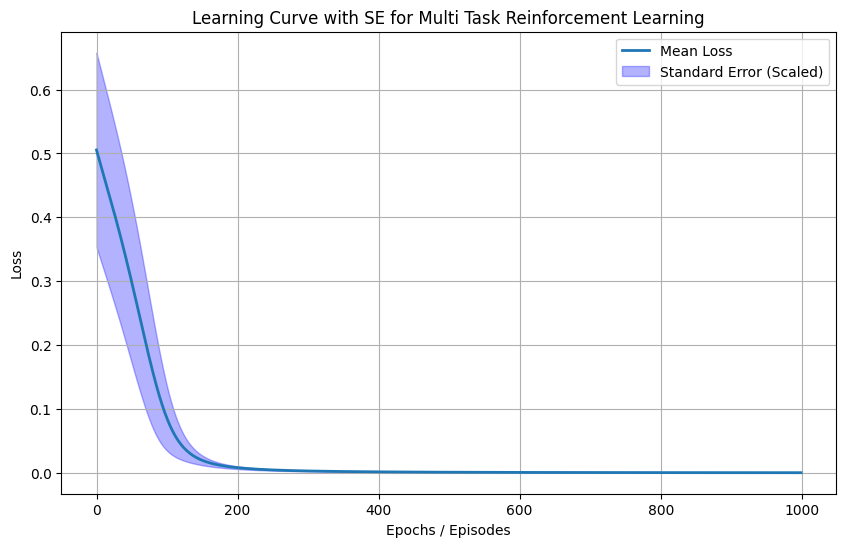

In [ ]:
plot_standard_error(mean_losses_reinforce, std_err_losses_reinforce, 'Learning Curve with SE for Multi Task Reinforcement Learning')